# 1. Activate GPU and Install Dependencies

In [1]:
import time
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os
import shutil
import torch
import tensorflow as tf
import tensorflow_hub as hub


import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')


In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/NLP/subjective_reviews.csv')

In [5]:
df.head()

,Unnamed: 0,Unnamed: 0.1,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review,polarity,cleaned_text,tb_subjectivity,tb_polarity,pos_tags,senti_score,swn_subjectivity
0,1,5701,670062510,5,A great book for young people. It has a great...,NaN,My favorite book when I was young. I read it ...,True,children,Language.ENGLISH,A great book for young people. It has a great...,1,A great book for young people. It has a great...,0.539394,0.271633,"[('A', 'DT'), ('great', 'JJ'), ('book', 'NN'),...",1.125,1
1,3,5021,399226907,5,Add this book to your collection,NaN,Cute and educational book to teach counting an...,True,children,Language.ENGLISH,Add this book to your collection. Cute and edu...,1,Add this book to your collection. Cute and edu...,0.580000,0.355000,"[('Add', 'VB'), ('this', 'DT'), ('book', 'NN')...",1.000,1
2,4,21354,125030170X,2,Just okay.,NaN,This is one of those books you can read in a c...,False,children,Language.ENGLISH,Just okay.. This is one of those books you can...,0,Just okay.. This is one of those books you can...,0.500000,0.500000,"[('Just', 'RB'), ('okay', 'RB'), ('..', 'VB'),...",0.500,1
3,5,23286,63215381,1,The paperback‚Äôs quality sucks,1,I hate this paperback. Terrible quality! The p...,True,children,Language.ENGLISH,The paperback‚Äôs quality sucks. I hate this p...,0,The paperback‚Äôs quality sucks. I hate this p...,0.697778,-0.490000,"[('The', 'DT'), ('paperback‚Äôs', 'NN'), ('qua...",-1.375,1
4,7,15810,1984806734,4,4.5 Fantastic Stars!!!,One person found this helpful,I‚Äôve seen people rate this book highly for m...,False,romance,Language.ENGLISH,4.5 Fantastic Stars!!!. I‚Äôve seen people rat...,1,4.5 Fantastic Stars!!!. I‚Äôve seen people rat...,0.588545,0.203599,"[('4.5', 'CD'), ('Fantastic', 'JJ'), ('Stars',...",10.375,1


In [6]:
df['polarity'].value_counts()

1    9593
0    3617
Name: polarity, dtype: int64

In [ ]:
# # use balanced data later
# remove_n = 5728

# to_remove = np.random.choice(df[df['polarity']==1].index,size=remove_n,replace=False)
# df = df.drop(to_remove)
# df = df[df.polarity != 0]
# df['polarity'].value_counts()

 1    7518
-1    7518
Name: polarity, dtype: int64

In [ ]:
# # negative to 0
# df.loc[df['polarity'] == -1, 'polarity'] = 0
# df['polarity'].value_counts()

1    7518
0    7518
Name: polarity, dtype: int64

In [ ]:
# df.loc[df.polarity == 0].sample(5)[['concat_review', 'polarity']]

,concat_review,polarity
16881,Pure drivel. I'm reaching the point where the ...,0
12832,"Unsupervised kids, trying to grow up, failing,...",0
19390,How did this get so many good reviews???. The ...,0
5458,Crazy Love. I really enjoyed this gem. The cha...,0
8146,Terrible book! So predictable and full of clic...,0


In [7]:
# Get the lists of sentences and their labels.
sentences = df.cleaned_text.values
labels = df.polarity.values

In [8]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 34.5 MB/s 
     |████████████████████████████████| 7.6 MB 57.9 MB/s 
     |████████████████████████████████| 163 kB 67.6 MB/s 


In [9]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
# **TEST ONLY**

# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  A great book for young people.  It has a great story.. My favorite book when I was young.  I read it about 30 times in my 60 odd years.  It‚Äôs been a few years so am going to read it again.  I bought a new copy in Florida.  My original is at home in Canada.
Tokenized:  ['a', 'great', 'book', 'for', 'young', 'people', '.', 'it', 'has', 'a', 'great', 'story', '.', '.', 'my', 'favorite', 'book', 'when', 'i', 'was', 'young', '.', 'i', 'read', 'it', 'about', '30', 'times', 'in', 'my', '60', 'odd', 'years', '.', 'it', '‚', 'ao', '##s', 'been', 'a', 'few', 'years', 'so', 'am', 'going', 'to', 'read', 'it', 'again', '.', 'i', 'bought', 'a', 'new', 'copy', 'in', 'florida', '.', 'my', 'original', 'is', 'at', 'home', 'in', 'canada', '.']
Token IDs:  [1037, 2307, 2338, 2005, 2402, 2111, 1012, 2009, 2038, 1037, 2307, 2466, 1012, 1012, 2026, 5440, 2338, 2043, 1045, 2001, 2402, 1012, 1045, 3191, 2009, 2055, 2382, 2335, 1999, 2026, 3438, 5976, 2086, 1012, 2009, 1522, 20118, 2015, 2042, 103

In [11]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  3357


# Our max length more than 512 should be this issue

In [12]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences. max 512 
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  A great book for young people.  It has a great story.. My favorite book when I was young.  I read it about 30 times in my 60 odd years.  It‚Äôs been a few years so am going to read it again.  I bought a new copy in Florida.  My original is at home in Canada.
Token IDs: tensor([  101,  1037,  2307,  2338,  2005,  2402,  2111,  1012,  2009,  2038,
         1037,  2307,  2466,  1012,  1012,  2026,  5440,  2338,  2043,  1045,
         2001,  2402,  1012,  1045,  3191,  2009,  2055,  2382,  2335,  1999,
         2026,  3438,  5976,  2086,  1012,  2009,  1522, 20118,  2015,  2042,
         1037,  2261,  2086,  2061,  2572,  2183,  2000,  3191,  2009,  2153,
         1012,  1045,  4149,  1037,  2047,  6100,  1999,  3516,  1012,  2026,
         2434,  2003,  2012,  2188,  1999,  2710,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   

In [13]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

11,889 training samples
1,321 validation samples


In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [16]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [17]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [18]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 3, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [19]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [21]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # loss, logits = model(b_input_ids, 
        #                      token_type_ids=None, 
        #                      attention_mask=b_input_mask, 
        #                      labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            # (loss, logits) = model(b_input_ids, 
            #                        token_type_ids=None, 
            #                        attention_mask=b_input_mask,
            #                        labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    372.    Elapsed: 0:00:27.
  Batch    80  of    372.    Elapsed: 0:00:52.
  Batch   120  of    372.    Elapsed: 0:01:17.
  Batch   160  of    372.    Elapsed: 0:01:42.
  Batch   200  of    372.    Elapsed: 0:02:08.
  Batch   240  of    372.    Elapsed: 0:02:33.
  Batch   280  of    372.    Elapsed: 0:02:59.
  Batch   320  of    372.    Elapsed: 0:03:26.
  Batch   360  of    372.    Elapsed: 0:03:53.

  Average training loss: 0.15
  Training epcoh took: 0:04:01

Running Validation...
  Accuracy: 0.98
  Validation Loss: 0.06
  Validation took: 0:00:10

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    372.    Elapsed: 0:00:27.
  Batch    80  of    372.    Elapsed: 0:00:53.
  Batch   120  of    372.    Elapsed: 0:01:20.
  Batch   160  of    372.    Elapsed: 0:01:46.
  Batch   200  of    372.    Elapsed: 0:02:12.
  Batch   240  of    372.    Elapsed: 0:02:39.
  Batch   280  of    372.    Elapsed: 0:03:05.
  Batch  

In [22]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.15,0.06,0.98,0:04:01,0:00:10
2,0.05,0.07,0.98,0:04:07,0:00:10
3,0.03,0.06,0.98,0:04:04,0:00:10
4,0.01,0.07,0.99,0:04:04,0:00:10


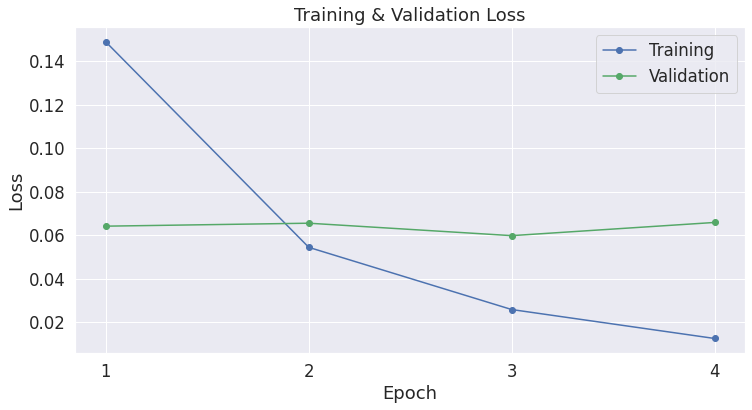

In [23]:
import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [24]:
df_test1 = pd.read_csv('/content/drive/MyDrive/NLP/test_df_Gx.csv')
df_test2 = pd.read_csv('/content/drive/MyDrive/NLP/test_df_Kelvin.csv')
df_test3 = pd.read_csv('/content/drive/MyDrive/NLP/test_df_Bryson.csv')

In [25]:
df_test1.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,Annotator_1,Annotator_2
0,0,0,16198,1984806734,5,Gus and January!,NaN,I desperately wanted to read the last third of...,True,romance,Language.ENGLISH,1,1
1,1,1,11211,1542046599,5,Intriguing,NaN,This book was very intriguing! I was guessing ...,True,mystery,Language.ENGLISH,1,1
2,2,2,8061,1484707230,5,Great series,NaN,My kid is 8. He loved reading these series at ...,True,children,Language.ENGLISH,1,1
3,3,3,23710,399562494,1,Seems like a plagiarism of The Book Woman of T...,11,How can I give even one star for Jojo Moyes bo...,False,children,Language.ENGLISH,-1,-1
4,4,4,19796,145217380X,1,John Oliver - you have outdone yourself this time,3,Thoroughly enjoyed reading this fun book. Hope...,True,children,Language.ENGLISH,1,1


In [26]:
df_test2.head()

,Unnamed: 0,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,Annotator1
0,22808,1501161938,1,Predictable and trite.,2,If you assume white straight men are all idiot...,False,children,Language.ENGLISH,-1
1,7497,1589255518,5,Classic Bedtime Story,NaN,This is one of my children‚Äôs all time favori...,True,children,Language.ENGLISH,1
2,170,451524934,5,We are living 1984,2 people found this helpful,You can thank Brandon for that,True,humor_entertainment,Language.ENGLISH,1
3,7470,B01M0JHBEG,5,Baby LOVES this book and so does mom!,NaN,The illustrations and lift the flaps are just ...,True,children,Language.ENGLISH,1
4,8608,141501596,5,Lovely,NaN,This is a classic! I loved this book as a kid ...,True,children,Language.ENGLISH,1


In [27]:
df_test3.head()

,Unnamed: 0,Unnamed: 0.1,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,Annotator_1,Annotator_2
0,0,24031,1982137452,1,The content is all messed up,NaN,I started this book this week for my book club...,True,children,Language.ENGLISH,-1,-1
1,1,22332,125030170X,1,Duplicate copy.Damaged book.,NaN,Pages missing.,True,children,Language.ENGLISH,-1,-1
2,2,23579,63215381,1,Awful,NaN,I gave up after 38% of my Kindle. Yes we were ...,True,children,Language.ENGLISH,-1,-1
3,3,20346,60935464,1,Syrupy Overload,3,The book is an example of leading the witness.,True,children,Language.ENGLISH,-1,-1
4,4,22874,1501161938,1,Couldn‚Äôt read it; type too small!,1,"Beware, the type is TINY, I mean TINY. I am 60...",True,children,Language.ENGLISH,-1,-1


In [28]:
df_test1['Annotator_1'].value_counts()

 1    533
-1    229
 0     16
Name: Annotator_1, dtype: int64

In [29]:
df_test2['Annotator1'].value_counts()

 1    504
-1    203
 0     69
Name: Annotator1, dtype: int64

In [30]:
df_test3['Annotator_1'].value_counts()

 1    542
-1    216
 0     18
Name: Annotator_1, dtype: int64

In [31]:
df_test1 = df_test1[df_test1.Annotator_1 != 0]
df_test2 = df_test2[df_test2.Annotator1 != 0]
df_test3 = df_test3[df_test3.Annotator_1 != 0]


In [32]:
# negative to 0
df_test1.loc[df_test1['Annotator_1'] == -1, 'Annotator_1'] = 0
df_test1['Annotator_1'].value_counts()

1    533
0    229
Name: Annotator_1, dtype: int64

In [33]:
# negative to 0
df_test2.loc[df_test2['Annotator1'] == -1, 'Annotator1'] = 0
df_test2['Annotator1'].value_counts()

1    504
0    203
Name: Annotator1, dtype: int64

In [34]:
# negative to 0
df_test3.loc[df_test3['Annotator_1'] == -1, 'Annotator_1'] = 0
df_test3['Annotator_1'].value_counts()

1    542
0    216
Name: Annotator_1, dtype: int64

In [ ]:
# df_test1.loc[df_test1.Annotator_1 == 0].sample(5)[['reviewDescription', 'Annotator_1']]

In [35]:

desc = (df_test1.reviewDescription).append((df_test2.reviewDescription).append(df_test3.reviewDescription))
anno = (df_test1.Annotator_1).append((df_test2.Annotator1).append(df_test3.Annotator_1))

In [36]:
# Get the lists of sentences and their labels.
sentences = desc.values
labels = anno.values

In [37]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [38]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []
total_t0 = time.time()
# Predict 
for step, batch in enumerate(prediction_dataloader):
  # Add batch to GPU
  t0 = time.time()
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  
predict_time = format_time(time.time() - total_t0)
print("  Predicting took: {:}".format(predict_time))
print('    DONE.')

Predicting labels for 2,227 test sentences...
  Predicting took: 0:00:16
    DONE.


In [ ]:
# print('Positive samples: %d of %d (%.2f%%)' % (df_test1.Annotator_1.sum(), len(df_test1.Annotator_1), (df_test1.Annotator_1.sum() / len(df_test1.Annotator_1) * 100.0)))

In [39]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [40]:
#dont use matthews
pred_label = []
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  pred_label.append(pred_labels_i) 

print(true_labels)
print('---')
print(pred_label)

[array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0]), array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0]), array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0]), array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0]), array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0]), array([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1]), array([0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1]), array([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1]), array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0,

In [41]:

correct_flat = [item for sublist in true_labels for item in sublist]
predicted_flat = [item for sublist in pred_label for item in sublist]

from sklearn.metrics import classification_report
print(classification_report(correct_flat, predicted_flat))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       648
           1       0.97      0.97      0.97      1579

    accuracy                           0.96      2227
   macro avg       0.95      0.94      0.95      2227
weighted avg       0.96      0.96      0.96      2227



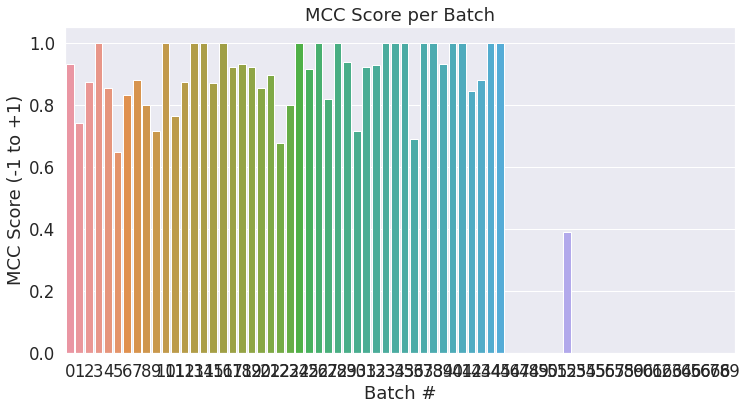

In [42]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [43]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.892


In [ ]:
output_dir = '/Users/nikomii/Documents/CZ4045/BERT-Saved/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


In [ ]:
!cp -r '/Users/nikomii/Documents/CZ4045/BERT-Saved/' '/content/drive/MyDrive/NLP'

Ref: https://mccormickml.com/2019/07/22/BERT-fine-tuning/